# E-Mini S&P500先物60分足の値動きと他の市場との相関分析

## 目的
他の市場の値動きから、S&P先物の値動きを予測することで仕掛け方向を見極める。

## 仮説
- E-MiniS&P500先物とE-Miniダウ先物の値動きは正相関する
- E-MiniS&P500先物と10年T-Notes先物の値動きは正相関する
- E-MiniS&P500先物と2年T-Notes先物の値動きは正相関する
- E-MiniS&P500先物と5年T-Notes先物の値動きは正相関する
- E-MiniS&P500先物と30年T-Bond先物の値動きは正相関する
- E-MiniS&P500先物とユーロドルの値動きは正相関する（1ドル＝何ユーロか、つまりこの数字が上がればドルが上がっているということ）
- E-MiniS&P500先物とドル円の値動きは負相関する（1円＝何ドルか、つまりこの数字が上がればドルが下がっているということ）
- E-MiniS&P500先物と金先物の値動きは負相関する
- E-MiniS&P500先物とE-Mini原油先物の値動きは負相関する

## 結果

### S&P500先物と正相関するもの
- 強い方から順に、ダウ先物、原油先物。
- 金先物はほぼ無相関

### 負相関するもの
- ほぼ同等だけど強い方から順に、10年、5年、30年、2年

### 相関傾向の一貫性
市場間の値動き相関を年毎に計算した。
- S&P500とダウは一貫して強い正相関を持つ
- S&P500と原油は、年によってばらつきがあるがおおむね正相関している。2004、2005はわずかに負相関だった。
- S&P500と金は、年によって正だったり負だったりする。ばらつきが大きい
- S&P500と金利は、年によるばらつきはあるものの、2005以外は一貫して負相関だった。

## 考察
### 相関分析結果について
- ここでは単純な同じ時間の値動きの相関を見た。
- N足ずらすと違った傾向が見えてくる可能性もある。
- 例えば、金利先物が上がった数足後にS&P500先物が上がるとか。
- ダウ先物が上がったが同時刻にS&P500先物が上がらなかったら、次の足でS&P500先物が上がるとか。

### 相関傾向の一貫性について
- ダウとの強い正相関は一貫しているから信頼できそうだ。
- 原油との正相関も比較的一貫しているから信頼できそうだ。
- 金との相関は一貫していないから使わない方がよさそうだ。
- 金利との相関は比較的一貫しているから使用できそうだ。

### まとめ
同時刻の値動きについては、
- S&P500先物とダウ先物は強い正相関
- S&P500先物と原油先物は弱い正相関
- S&P500先物と金利10年先物は弱い負相関

として利用できる。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-60min.csv')

dow_dir = 'data/e-mini-dow-200626'
df_dow_raw = pd.read_csv(f'{dow_dir}/e-mini-dow-60min.csv')

oil_dir = 'data/e-mini-crude-oil-200626'
df_oil_raw = pd.read_csv(f'{oil_dir}/e-mini-crude-oil-60min.csv')

gold_dir = 'data/gold-200626'
df_gold_raw = pd.read_csv(f'{gold_dir}/gold-60min.csv')

tnote2_dir = 'data/t-notes-2yr-200626'
df_tnote2_raw = pd.read_csv(f'{tnote2_dir}/t-notes-2yr-60min.csv')

tnote5_dir = 'data/t-notes-5yr-200626'
df_tnote5_raw = pd.read_csv(f'{tnote5_dir}/t-notes-5yr-60min.csv')

tnote10_dir = 'data/t-notes-10yr-200626'
df_tnote10_raw = pd.read_csv(f'{tnote10_dir}/t-notes-10yr-60min.csv')

tbond30_dir = 'data/t-bond-30yr-200629'
df_tbond30_raw = pd.read_csv(f'{tbond30_dir}/t-bond-30yr-60min.csv')

dfnames = ['sp', 'dow', 'oil', 'gold', 'tnote2', 'tnote5', 'tnote10', 'tbond30']
dfraws = [df_sp_raw, df_dow_raw, df_oil_raw, df_gold_raw, df_tnote2_raw, df_tnote5_raw, df_tnote10_raw, df_tbond30_raw]
#dfraws = [df_sp_raw, df_dow_raw, df_oil_raw, df_gold_raw]
#dfraws = [df_sp_raw, df_dow_raw]

In [3]:
dfraws[0].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,05:00,1082.25,1082.25,1079.75,1079.75,5,0


In [4]:
dfraws[1].head(1)

,Date,Time,Open,High,Low,Close,Vol,OI
0,04/05/2002,08:00,8409,8415,8409,8415,156,0


In [5]:
dfraws[2].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,07/08/2002,11:00,115.83,115.83,115.455,115.63,318,380


In [6]:
dfraws[3].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,09/22/2002,22:00,656.6,656.6,656.6,656.6,10,0


In [7]:
dfraws[4].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,05/02/2001,17:00,85.292969,85.292969,85.292969,85.292969,1,0


In [8]:
dfraws[5].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,05/14/2001,01:00,61.023438,61.023438,61.023438,61.023438,0,99


In [9]:
dfraws[6].head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,05/13/2001,22:00,45.015625,45.015625,44.78125,44.953125,4488,652


In [10]:
dfraws[7].head(1)

,Date,Time,Open,High,Low,Close,Up,Down,RSI,OverBot,OverSld
0,05/13/2001,22:00,42.78125,42.78125,42.625,42.71875,6640,1311,0.0,0.0,0.0


# 値動きに相関があるか
値動きとは
- 終値 - 前足の終値
- 終値 - 始値
- 高値 - 安値
- 真の値幅

などがある。まずは（終値 - 前足の終値）の相関性を見てみる

In [11]:
dfs = []
for df in dfraws:
    dfs.append(df.copy())

In [12]:
def to_datetime_idx(df):
    df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    return df.set_index('DT')

for i, df in enumerate(dfs):
    dfs[i] = to_datetime_idx(df)

In [13]:
# 終値の変化量
COL_NAME = 'CSlopeR'
TARGET_COL = 'Close'

def slope(xs, fill_first_with_na=True):
    ys = np.convolve(xs, np.array([1,-1]), 'valid')
    if fill_first_with_na:
        ys = np.append(np.array([np.nan]), ys)

    return ys

def slope_ratio(xs, fill_first_with_na=True):
    ys = np.convolve(xs, np.array([1,-1]), 'valid') / xs[:-1]
    if fill_first_with_na:
        ys = np.append(np.array([np.nan]), ys)

    return ys

for i, df in enumerate(dfs):
    dfs[i][COL_NAME] = slope_ratio(df[TARGET_COL].to_numpy()) 

In [14]:
cslopers = dfs[0].loc[:, [COL_NAME]].rename(columns={COL_NAME:dfnames[0]})
for i in range(1, len(dfs)):
    cslopers = cslopers.merge(dfs[i].loc[:, [COL_NAME]].rename(columns={COL_NAME:dfnames[i]}), how='outer', left_index=True, right_index=True)

In [15]:
# NaNを含む行を全部削除
cslopers = cslopers[cslopers.notnull().all(axis=1)]

In [16]:
cslopers.corr()

,sp,dow,oil,gold,tnote2,tnote5,tnote10,tbond30
sp,1.000000,0.974222,0.278568,0.066501,-0.338670,-0.378553,-0.387785,-0.369356
dow,0.974222,1.000000,0.269615,0.058980,-0.331608,-0.368828,-0.377632,-0.359894
oil,0.278568,0.269615,1.000000,0.139558,-0.096936,-0.124005,-0.132889,-0.153194
gold,0.066501,0.058980,0.139558,1.000000,0.119961,0.130059,0.118281,0.109474
tnote2,-0.338670,-0.331608,-0.096936,0.119961,1.000000,0.842360,0.751426,0.606585
tnote5,-0.378553,-0.368828,-0.124005,0.130059,0.842360,1.000000,0.940152,0.800638
tnote10,-0.387785,-0.377632,-0.132889,0.118281,0.751426,0.940152,1.000000,0.883476
tbond30,-0.369356,-0.359894,-0.153194,0.109474,0.606585,0.800638,0.883476,1.000000


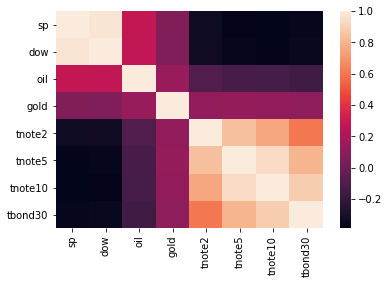

In [17]:
sns.heatmap(cslopers.corr())

# 市場間の相関傾向はどの程度安定しているのか

In [21]:
# 2002, 2003はデータが少ないから、使わない
for year in range(2002, 2021):
    print(f'{year}: {cslopers[str(year)].shape}')

2002: (16, 8)
2003: (199, 8)
2004: (1854, 8)
2005: (3335, 8)
2006: (3937, 8)
2007: (5346, 8)
2008: (5780, 8)
2009: (5874, 8)
2010: (5890, 8)
2011: (5883, 8)
2012: (5810, 8)
2013: (5704, 8)
2014: (5837, 8)
2015: (5892, 8)
2016: (5897, 8)
2017: (5873, 8)
2018: (5831, 8)
2019: (5890, 8)
2020: (2423, 8)


In [63]:
# 2004年以降で1年ごとにS&P500先物と他の市場との相関を見る
cslopers04_20 = cslopers['2004':]
cslopers04_20['year'] = cslopers04_20.index.map(lambda x: x.year)

cslopers_yearly = pd.DataFrame()
for name, group in cslopers04_20.groupby('year'):
    group = group.drop(['year'], axis=1)
    row = group.corr().loc[['sp'],:]
    row.index = [name]
    cslopers_yearly = pd.concat([cslopers_yearly, row])

cslopers_yearly

<ipython-input-63-6c1f4f02933e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cslopers04_20['year'] = cslopers04_20.index.map(lambda x: x.year)


,sp,dow,oil,gold,tnote2,tnote5,tnote10,tbond30
2004,1.0,0.938011,-0.091037,-0.083934,-0.108088,-0.158478,-0.165237,-0.154299
2005,1.0,0.932663,-0.031617,0.012411,-0.073483,-0.071861,-0.055896,-0.029063
2006,1.0,0.919570,0.005167,0.102323,0.034392,0.007023,-0.011787,-0.026746
2007,1.0,0.949037,0.113857,0.236687,-0.475823,-0.488557,-0.467985,-0.392477
2008,1.0,0.982777,0.283098,0.102364,-0.429379,-0.445001,-0.446242,-0.407722
2009,1.0,0.977551,0.442831,0.139385,-0.295194,-0.319582,-0.315608,-0.317997
2010,1.0,0.974375,0.605229,0.232752,-0.377969,-0.436704,-0.464267,-0.475547
2011,1.0,0.976676,0.527735,0.127068,-0.300563,-0.495760,-0.554943,-0.551455
2012,1.0,0.955648,0.505821,0.363963,-0.182204,-0.439987,-0.506230,-0.531970
2013,1.0,0.953188,0.262308,0.069917,0.016256,-0.042788,-0.112278,-0.178198


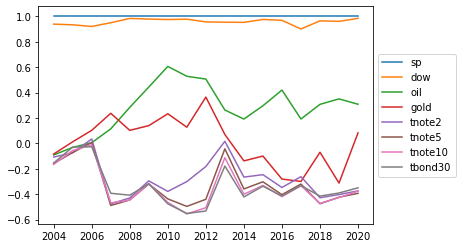

In [65]:
cslopers_yearly.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))